In [1]:
import os
import sys
import math
import copy 
import torch 
import random
DEBUG = False
import numpy as np
import torch_sparse
import pandas as pd 
import pickle as pkl
from tqdm import tqdm
from time import time
import networkx as nx
from dgl import DGLGraph
from scipy import linalg
from pathlib import Path
from torch import Tensor
import scipy.sparse as sp
from random import randint
from dgl import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from scipy import sparse, stats
from scipy.sparse import csgraph
from scipy.sparse import csr_matrix
from dgl import from_networkx, DGLGraph
from torch_geometric.utils import scatter
from dgl.data import citation_graph as citegrh
from torch_geometric.typing import SparseTensor
from torch_geometric.utils import to_undirected
from torch_geometric.utils import remove_self_loops
from sklearn.metrics.pairwise import cosine_similarity
# from ipynb.fs.full.Dataset import get_data_from_dataset
# from ipynb.fs.full.Dataset import get_data_from_dataset,train_val_test_mask
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from typing import Callable, List, NamedTuple, Optional, Tuple, Union
from torch_geometric.utils import add_self_loops,add_remaining_self_loops
# from ipynb.fs.full.SpectralSparsifier import EffectiveResistance, LocalEffectiveResistance, get_sparse_adj_matrix

In [2]:
import numpy as np
import torch
import pickle as pkl
import sys
import networkx as nx
import numpy as np
import scipy.sparse as sp

import argparse
import time
from time import localtime
import torch
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
import random
from torch.backends import cudnn
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import dgl.function as fn
from dgl.nn.pytorch import edge_softmax
import numpy as np
import torch.nn.functional as F

import torch
import torch.nn as nn
import dgl.function as fn
from dgl.nn.pytorch import edge_softmax
import numpy as np
import torch.nn.functional as F


In [3]:
import torch
from contextlib import contextmanager
import subprocess
import re

# # At the start of your script
# torch.cuda.reset_peak_memory_stats()  # Reset memory statistics

# # ... your training loop ...

# # Get max memory used (in bytes)
# max_memory = torch.cuda.max_memory_allocated()
# print(f"Max GPU memory used: {max_memory / 1024**2:.2f} MB")

# # Optionally, get memory by device if using multiple GPUs
# for i in range(torch.cuda.device_count()):
#     max_memory = torch.cuda.max_memory_allocated(i)
#     print(f"Max GPU memory used on device {i}: {max_memory / 1024**2:.2f} MB")


# @contextmanager
# def track_memory_usage(description="", device=None):
#     if device is None:
#         device = torch.cuda.current_device()
#     torch.cuda.synchronize(device)
#     torch.cuda.reset_peak_memory_stats(device)
#     yield
#     torch.cuda.synchronize(device)
#     max_memory = torch.cuda.max_memory_allocated(device)
#     print(f"{description} Max GPU memory used: {max_memory / 1024**2:.2f} MB")
    
def get_gpu_memory_usage():
    result = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'])
    memory_usage = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return memory_usage

# Call this periodically during training to track memory usage
get_gpu_memory_usage()

[750]

In [4]:
import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

In [5]:
from ipynb.fs.full.SGSLoadDataset import LOAD_DATASET, train_val_test_mask

DATASET_NAME = "moon"
data, dataset  = LOAD_DATASET(DIR, DATASET_NAME)
num_classes = max(data.y).item()+1
# if DATASET_NAME == "wiki":
#     data = train_val_test_mask(data, train=0.2, val=0.4, test=0.4, random_state=False)
# data
if len(data.train_mask.shape)>1:
    index = 0
    data.train_mask = data.train_mask[:,index]
    data.val_mask = data.val_mask[:,index]
    if DATASET_NAME == 'wiki':
        None
    else:
        data.test_mask = data.test_mask[:,index]
    
data

moon N: 100 E: 596 F: 2 C: 2 d: 5.96 lr: 0.20 i: False s: False u: True


Data(x=[100, 2], edge_index=[2, 596], y=[100], train_mask=[100], val_mask=[100], test_mask=[100], edge_weight=[596, 1])

In [6]:
from ipynb.fs.full.Moon import MoonDataset

DATASET_NAME = "moon"
dataset = MoonDataset(n_samples=150, degree=4, train=0.3, h=0.2)
data = dataset[0]

if "train_mask" not in data.__dict__["_store"]:
    data = train_val_test_mask(data, train=0.3, val=0.3, test=0.4, random_state=False)

num_classes = max(data.y).item() + 1


In [7]:
sig = nn.Sigmoid()
hardtanh = nn.Hardtanh(0,1)
gamma = -0.1
zeta = 1.1
beta = 0.66
eps = 1e-20
const1 = beta*np.log(-gamma/zeta + eps)

def l0_train(logAlpha, min, max):
    U = torch.rand(logAlpha.size()).type_as(logAlpha) + eps
    s = sig((torch.log(U / (1 - U)) + logAlpha) / beta)
    s_bar = s * (zeta - gamma) + gamma
    mask = F.hardtanh(s_bar, min, max)
    return mask

def l0_test(logAlpha, min, max):
    s = sig(logAlpha/beta)
    s_bar = s * (zeta - gamma) + gamma
    mask = F.hardtanh(s_bar, min, max)
    return mask

def get_loss2(logAlpha):
    return sig(logAlpha - const1)


class GraphAttention(nn.Module):
    def __init__(self,
                 g,
                 in_dim,
                 out_dim,
                 num_heads,
                 feat_drop,
                 attn_drop,
                 alpha,
                 bias_l0,
                 residual=False,l0=0, min=0):
        super(GraphAttention, self).__init__()
        self.g = g
        self.num_heads = num_heads
        self.fc = nn.Linear(in_dim, num_heads * out_dim, bias=False)
        if feat_drop:
            self.feat_drop = nn.Dropout(feat_drop)
        else:
            self.feat_drop = lambda x : x
        if attn_drop:
            self.attn_drop = nn.Dropout(attn_drop)
        else:
            self.attn_drop = lambda x : x
        self.attn_l = nn.Parameter(torch.Tensor(size=(1, 1, out_dim)))
        self.attn_r = nn.Parameter(torch.Tensor(size=(1, 1, out_dim)))
        self.bias_l0 = nn.Parameter(torch.FloatTensor([bias_l0]))

        nn.init.xavier_normal_(self.fc.weight.data, gain=1.414)
        nn.init.xavier_normal_(self.attn_l.data, gain=1.414)
        nn.init.xavier_normal_(self.attn_r.data, gain=1.414)
        self.leaky_relu = nn.LeakyReLU(alpha)
        self.softmax = edge_softmax
        self.residual = residual
        self.num = 0
        self.l0 = l0
        self.loss = 0
        self.dis = []
        self.min=min
        if residual:
            if in_dim != out_dim:
                self.res_fc = nn.Linear(in_dim, num_heads * out_dim, bias=False)
                nn.init.xavier_normal_(self.res_fc.weight.data, gain=1.414)
            else:
                self.res_fc = None

    def forward(self, inputs, edges="__ALL__", skip=0):
        self.loss = 0
        # prepare
        h = self.feat_drop(inputs)  # NxD
        ft = self.fc(h).reshape((h.shape[0], self.num_heads, -1))  # NxHxD'
        a1 = (ft * self.attn_l).sum(dim=-1).unsqueeze(-1) # N x H x 1
        a2 = (ft * self.attn_r).sum(dim=-1).unsqueeze(-1) # N x H x 1
      
        self.g.ndata.update({'ft' : ft, 'a1' : a1, 'a2' : a2})

        if skip == 0:
            # 1. compute edge attention
            self.g.apply_edges(self.edge_attention, edges)

            # 2. compute softmax
            if self.l0 == 1:
                ind = self.g.nodes()
                self.g.apply_edges(self.loop, edges=(ind, ind))

            self.edge_softmax()

            if self.l0 == 1:
                self.g.apply_edges(self.norm)

        # 2. compute the aggregated node features scaled by the dropped,
            edges = self.g.edata['a'].squeeze().nonzero().squeeze()


        self.g.edata['a_drop'] = self.attn_drop(self.g.edata['a'])
        self.num = (self.g.edata['a'] > 0).sum()
        self.g.update_all(fn.u_mul_e('ft', 'a_drop', 'ft'), fn.sum('ft', 'ft'))
        ret = self.g.ndata['ft']

        # 4. residual
        if self.residual:
            if self.res_fc is not None:
                resval = self.res_fc(h).reshape((h.shape[0], self.num_heads, -1))  # NxHxD'
            else:
                resval = torch.unsqueeze(h, 1)  # Nx1xD'
            ret = resval + ret
        return ret, edges

    def edge_attention(self, edges):
        # an edge UDF to compute unnormalized attention values from src and dst
        if self.l0 == 0:
            m = self.leaky_relu(edges.src['a1'] + edges.dst['a2'])
        else:
            tmp = edges.src['a1'] + edges.dst['a2']
            logits = tmp + self.bias_l0

            if self.training:
                m = l0_train(logits, 0, 1)
            else:
                m = l0_test(logits, 0, 1)
            self.loss = get_loss2(logits[:,0,:]).sum()
        return {'a': m}

    def norm(self, edges):
        # normalize attention
        a = edges.data['a'] / edges.dst['z']
        return {'a' : a}

    def loop(self, edges):
        # set attention to itself as 1
        return {'a': torch.pow(edges.data['a'], 0)}

    def normalize(self, logits):
        self._logits_name = "_logits"
        self._normalizer_name = "_norm"
        self.g.edata[self._logits_name] = logits
        self.g.update_all(fn.copy_edge(self._logits_name, self._logits_name),
                         fn.sum(self._logits_name, self._normalizer_name))
        return self.g.edata.pop(self._logits_name), self.g.ndata.pop(self._normalizer_name)

    def edge_softmax(self):

        if self.l0 == 0:
            scores = self.softmax(self.g, self.g.edata.pop('a'))
        else:
            scores, normalizer = self.normalize(self.g.edata.pop('a'))
            self.g.ndata['z'] = normalizer[:,0,:].unsqueeze(1)

        self.g.edata['a'] = scores[:,0,:].unsqueeze(1)

class GAT(nn.Module):
    def __init__(self,
                 g,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 activation,
                 feat_drop,
                 attn_drop,
                 alpha,
                 bias_l0,
                 residual, l0=0):
        super(GAT, self).__init__()
        self.g = g
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = activation
        # input projection (no residual)
        self.gat_layers.append(GraphAttention(
            g, in_dim, num_hidden, heads[0], feat_drop, attn_drop, alpha,bias_l0, False, l0=l0, min=0))
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GraphAttention(
                g, num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, alpha,bias_l0, residual, l0=l0, min=0))
        # output projection
        self.gat_layers.append(GraphAttention(
            g, num_hidden * heads[-2], num_classes, heads[-1],
            feat_drop, attn_drop, alpha,bias_l0, residual, l0=l0))


    def forward(self, inputs):

        h = inputs
        edges = "__ALL__"
        h, edges = self.gat_layers[0](h, edges)
        h = self.activation(h.flatten(1))
        for l in range(1, self.num_layers):
            h, _= self.gat_layers[l](h, edges, skip=1)
            h = self.activation(h.flatten(1))

        # output projection
        logits,_ = self.gat_layers[-1](h, edges, skip=1)
        logits = logits.mean(1)
        return logits

utils .py

In [8]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def step(self, acc, model):
        score = acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            # print('EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), 'es_checkpoint.pt')

GAT . py

In [9]:
from sklearn.metrics import f1_score

def accuracy(logits, labels):
#     _, indices = torch.max(logits, dim=1)
#     correct = torch.sum(indices == labels)
#     return correct.item() * 1.0 / len(labels)
    preds = logits.argmax(dim=1)
    f1 = f1_score(labels.cpu(), preds.cpu(), average='micro')
    return f1
    

def evaluate(model, features, labels, mask,loss_fcn):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        loss_data = loss_fcn(logits, labels)
        return accuracy(logits, labels), loss_data

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if gpu >= 0:
        torch.cuda.manual_seed(seed)
        cudnn.benchmark = False
        cudnn.deterministic = True

In [10]:
num_out_heads = 4
num_heads = 15
num_layers = 2
gpu = -1
l0 = 0
num_hidden = 128
residual = False 
idrop = 0.6
adrop = 0.6
lr = 0.005 
weight_decay = 5e-4
alpha = 0.2
early_stop = True 
fastmode = False 
seed = 123 
bias = 0 
loss_lo = 0 
syn_type = "scipy" 
self_loop = False 
sess ='default'
loss_l0  = 0
weight_decay = 0
l0 = 0

#data, dataset = get_data_from_dataset('cornell5')
epochs = 1500

data = data.to(device)

#features = torch.FloatTensor(data.x)
features = data.x
#labels = torch.LongTensor(data.y)
labels = data.y
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask
num_feats = features.shape[1]
n_classes = max(data.y).item()+1
n_edges = data.num_edges
current_time = time.strftime('%d_%H:%M:%S', localtime())
print("HELLO WORLD")

print("""----Data statistics------'
    #Edges %d
    #Classes %d
    #Train samples %d
    #Val samples %d
    #Test samples %d""" %
        (n_edges, n_classes,
        train_mask.sum().item(),
        val_mask.sum().item(),
        test_mask.sum().item()))

cuda = True

import dgl
from dgl.data.utils import generate_mask_tensor

g = dgl.graph((data.edge_index[0], data.edge_index[1]), num_nodes=data.x.size(0))

# Add node features
g.ndata['feat'] = data.x
g.ndata['label'] = data.y
# g.ndata['train_mask'] = generate_mask_tensor(data.train_mask.numpy())
# g.ndata['val_mask'] = generate_mask_tensor(data.val_mask.numpy())
# g.ndata['test_mask'] = generate_mask_tensor(data.test_mask.numpy())

g.ndata['train_mask'] = data.train_mask
g.ndata['val_mask'] = data.val_mask
g.ndata['test_mask'] = data.test_mask


n_edges = g.number_of_edges()
heads = ([num_heads] * num_layers) + [num_out_heads]

model = GAT(g,
            num_layers,
            num_feats,
            num_hidden,
            n_classes,
            heads,
            F.elu,
            idrop,
            adrop,
            alpha,
            bias,
            residual,
            l0).to(device)
print(model)

if early_stop:
    stopper = EarlyStopping(patience=150)
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
dur = []
time_used = 0

HELLO WORLD
----Data statistics------'
    #Edges 846
    #Classes 2
    #Train samples 45
    #Val samples 45
    #Test samples 60
GAT(
  (gat_layers): ModuleList(
    (0): GraphAttention(
      (fc): Linear(in_features=2, out_features=1920, bias=False)
      (feat_drop): Dropout(p=0.6, inplace=False)
      (attn_drop): Dropout(p=0.6, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GraphAttention(
      (fc): Linear(in_features=1920, out_features=1920, bias=False)
      (feat_drop): Dropout(p=0.6, inplace=False)
      (attn_drop): Dropout(p=0.6, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GraphAttention(
      (fc): Linear(in_features=1920, out_features=8, bias=False)
      (feat_drop): Dropout(p=0.6, inplace=False)
      (attn_drop): Dropout(p=0.6, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)


In [11]:
model

GAT(
  (gat_layers): ModuleList(
    (0): GraphAttention(
      (fc): Linear(in_features=2, out_features=1920, bias=False)
      (feat_drop): Dropout(p=0.6, inplace=False)
      (attn_drop): Dropout(p=0.6, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GraphAttention(
      (fc): Linear(in_features=1920, out_features=1920, bias=False)
      (feat_drop): Dropout(p=0.6, inplace=False)
      (attn_drop): Dropout(p=0.6, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GraphAttention(
      (fc): Linear(in_features=1920, out_features=8, bias=False)
      (feat_drop): Dropout(p=0.6, inplace=False)
      (attn_drop): Dropout(p=0.6, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)

In [12]:
dur = []
best_test_f1 = 0

for epoch in range(epochs):
    
    model.train()
    t0 = time.time()

    # forward
    logits = model(features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    loss_l0 = loss_l0*( model.gat_layers[0].loss)
    optimizer.zero_grad()
    (loss + loss_l0).backward()
    optimizer.step()
    dur.append(time.time() - t0)
    
#     print(get_gpu_memory_usage()[0], "MB")

    train_acc = accuracy(logits[train_mask], labels[train_mask])

    
    if fastmode:
        val_acc, loss = accuracy(logits[val_mask], labels[val_mask], loss_fcn)
    else:
        val_acc,_ = evaluate(model, features, labels, val_mask, loss_fcn)
#         if early_stop:
#             if stopper.step(val_acc, model):   
#                 break        
    
    print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | TrainAcc {:.4f} |"
            " ValAcc {:.4f} | ETputs(KTEPS) {:.2f}".format(epoch, np.mean(dur), loss.item(), train_acc,
                    val_acc, n_edges / np.mean(dur) / 1000))
# print(dataset.name)


print("Time per epoch: ", np.mean(dur))

Epoch 00000 | Time(s) 0.6548 | Loss 0.7111 | TrainAcc 0.4222 | ValAcc 0.5333 | ETputs(KTEPS) 1.29
Epoch 00001 | Time(s) 0.3300 | Loss 1.2951 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 2.56
Epoch 00002 | Time(s) 0.2216 | Loss 6.8172 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 3.82
Epoch 00003 | Time(s) 0.1674 | Loss 4.5660 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 5.05
Epoch 00004 | Time(s) 0.1349 | Loss 1.6450 | TrainAcc 0.4444 | ValAcc 0.5333 | ETputs(KTEPS) 6.27
Epoch 00005 | Time(s) 0.1132 | Loss 3.5487 | TrainAcc 0.5111 | ValAcc 0.5333 | ETputs(KTEPS) 7.47
Epoch 00006 | Time(s) 0.0977 | Loss 2.9640 | TrainAcc 0.5111 | ValAcc 0.5333 | ETputs(KTEPS) 8.66
Epoch 00007 | Time(s) 0.0861 | Loss 1.6096 | TrainAcc 0.4667 | ValAcc 0.7111 | ETputs(KTEPS) 9.83
Epoch 00008 | Time(s) 0.0770 | Loss 1.0417 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 10.98
Epoch 00009 | Time(s) 0.0698 | Loss 2.1910 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 12.12
Epoch 00010 | Time

Epoch 00090 | Time(s) 0.0119 | Loss 0.6956 | TrainAcc 0.5778 | ValAcc 0.5333 | ETputs(KTEPS) 71.01
Epoch 00091 | Time(s) 0.0118 | Loss 0.8960 | TrainAcc 0.5556 | ValAcc 0.5333 | ETputs(KTEPS) 71.45
Epoch 00092 | Time(s) 0.0118 | Loss 0.6902 | TrainAcc 0.5778 | ValAcc 0.5333 | ETputs(KTEPS) 71.92
Epoch 00093 | Time(s) 0.0117 | Loss 0.7005 | TrainAcc 0.5333 | ValAcc 0.5333 | ETputs(KTEPS) 72.38
Epoch 00094 | Time(s) 0.0116 | Loss 0.7226 | TrainAcc 0.6000 | ValAcc 0.5333 | ETputs(KTEPS) 72.83
Epoch 00095 | Time(s) 0.0115 | Loss 0.7472 | TrainAcc 0.3556 | ValAcc 0.5333 | ETputs(KTEPS) 73.29
Epoch 00096 | Time(s) 0.0115 | Loss 0.7344 | TrainAcc 0.4222 | ValAcc 0.5333 | ETputs(KTEPS) 73.74
Epoch 00097 | Time(s) 0.0114 | Loss 0.8315 | TrainAcc 0.4889 | ValAcc 0.5333 | ETputs(KTEPS) 74.19
Epoch 00098 | Time(s) 0.0113 | Loss 0.7536 | TrainAcc 0.5333 | ValAcc 0.5333 | ETputs(KTEPS) 74.63
Epoch 00099 | Time(s) 0.0113 | Loss 0.7233 | TrainAcc 0.5333 | ValAcc 0.4222 | ETputs(KTEPS) 75.08
Epoch 0010

Epoch 00180 | Time(s) 0.0083 | Loss 0.7283 | TrainAcc 0.5333 | ValAcc 0.4667 | ETputs(KTEPS) 101.47
Epoch 00181 | Time(s) 0.0083 | Loss 0.7584 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 101.69
Epoch 00182 | Time(s) 0.0083 | Loss 0.6725 | TrainAcc 0.6222 | ValAcc 0.4667 | ETputs(KTEPS) 101.93
Epoch 00183 | Time(s) 0.0083 | Loss 0.7541 | TrainAcc 0.5333 | ValAcc 0.3778 | ETputs(KTEPS) 102.18
Epoch 00184 | Time(s) 0.0083 | Loss 0.7125 | TrainAcc 0.4667 | ValAcc 0.3333 | ETputs(KTEPS) 102.41
Epoch 00185 | Time(s) 0.0082 | Loss 0.6559 | TrainAcc 0.4667 | ValAcc 0.4222 | ETputs(KTEPS) 102.65
Epoch 00186 | Time(s) 0.0082 | Loss 0.7538 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 102.87
Epoch 00187 | Time(s) 0.0082 | Loss 0.6815 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 103.11
Epoch 00188 | Time(s) 0.0082 | Loss 0.6743 | TrainAcc 0.6000 | ValAcc 0.4667 | ETputs(KTEPS) 103.34
Epoch 00189 | Time(s) 0.0082 | Loss 0.7023 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 103.56


Epoch 00270 | Time(s) 0.0071 | Loss 0.8127 | TrainAcc 0.4222 | ValAcc 0.4667 | ETputs(KTEPS) 118.36
Epoch 00271 | Time(s) 0.0071 | Loss 0.7944 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 118.50
Epoch 00272 | Time(s) 0.0071 | Loss 0.8879 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 118.64
Epoch 00273 | Time(s) 0.0071 | Loss 0.7109 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 118.80
Epoch 00274 | Time(s) 0.0071 | Loss 0.7260 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 118.95
Epoch 00275 | Time(s) 0.0071 | Loss 0.7198 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 119.10
Epoch 00276 | Time(s) 0.0071 | Loss 0.7387 | TrainAcc 0.5333 | ValAcc 0.4667 | ETputs(KTEPS) 119.24
Epoch 00277 | Time(s) 0.0071 | Loss 0.6775 | TrainAcc 0.5111 | ValAcc 0.4000 | ETputs(KTEPS) 119.38
Epoch 00278 | Time(s) 0.0071 | Loss 0.7064 | TrainAcc 0.5556 | ValAcc 0.3111 | ETputs(KTEPS) 119.54
Epoch 00279 | Time(s) 0.0071 | Loss 0.6962 | TrainAcc 0.4667 | ValAcc 0.4889 | ETputs(KTEPS) 119.68


Epoch 00360 | Time(s) 0.0065 | Loss 0.8467 | TrainAcc 0.5111 | ValAcc 0.4222 | ETputs(KTEPS) 129.27
Epoch 00361 | Time(s) 0.0065 | Loss 0.6780 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 129.37
Epoch 00362 | Time(s) 0.0065 | Loss 0.6984 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 129.45
Epoch 00363 | Time(s) 0.0065 | Loss 0.6919 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 129.54
Epoch 00364 | Time(s) 0.0065 | Loss 1.2231 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 129.64
Epoch 00365 | Time(s) 0.0065 | Loss 0.6889 | TrainAcc 0.4444 | ValAcc 0.5333 | ETputs(KTEPS) 129.75
Epoch 00366 | Time(s) 0.0065 | Loss 0.7921 | TrainAcc 0.4444 | ValAcc 0.5333 | ETputs(KTEPS) 129.84
Epoch 00367 | Time(s) 0.0065 | Loss 0.7317 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 129.93
Epoch 00368 | Time(s) 0.0065 | Loss 0.6949 | TrainAcc 0.4222 | ValAcc 0.3778 | ETputs(KTEPS) 130.02
Epoch 00369 | Time(s) 0.0065 | Loss 0.6862 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 130.12


Epoch 00450 | Time(s) 0.0062 | Loss 0.8238 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 136.88
Epoch 00451 | Time(s) 0.0062 | Loss 0.7683 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 136.93
Epoch 00452 | Time(s) 0.0062 | Loss 0.7171 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 137.00
Epoch 00453 | Time(s) 0.0062 | Loss 0.6678 | TrainAcc 0.5333 | ValAcc 0.4667 | ETputs(KTEPS) 137.07
Epoch 00454 | Time(s) 0.0062 | Loss 0.6993 | TrainAcc 0.5333 | ValAcc 0.4667 | ETputs(KTEPS) 137.13
Epoch 00455 | Time(s) 0.0062 | Loss 0.7247 | TrainAcc 0.6444 | ValAcc 0.4667 | ETputs(KTEPS) 137.21
Epoch 00456 | Time(s) 0.0062 | Loss 0.6929 | TrainAcc 0.5111 | ValAcc 0.3556 | ETputs(KTEPS) 137.27
Epoch 00457 | Time(s) 0.0062 | Loss 0.6965 | TrainAcc 0.5333 | ValAcc 0.3778 | ETputs(KTEPS) 137.35
Epoch 00458 | Time(s) 0.0062 | Loss 0.8825 | TrainAcc 0.4444 | ValAcc 0.3778 | ETputs(KTEPS) 137.42
Epoch 00459 | Time(s) 0.0062 | Loss 0.8105 | TrainAcc 0.4222 | ValAcc 0.3556 | ETputs(KTEPS) 137.49


Epoch 00540 | Time(s) 0.0059 | Loss 1.1641 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 142.38
Epoch 00541 | Time(s) 0.0059 | Loss 2.8076 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 142.43
Epoch 00542 | Time(s) 0.0059 | Loss 1.5683 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 142.48
Epoch 00543 | Time(s) 0.0059 | Loss 0.9639 | TrainAcc 0.5778 | ValAcc 0.4667 | ETputs(KTEPS) 142.53
Epoch 00544 | Time(s) 0.0059 | Loss 0.7671 | TrainAcc 0.5111 | ValAcc 0.4889 | ETputs(KTEPS) 142.58
Epoch 00545 | Time(s) 0.0059 | Loss 0.6971 | TrainAcc 0.5111 | ValAcc 0.3778 | ETputs(KTEPS) 142.64
Epoch 00546 | Time(s) 0.0059 | Loss 0.6874 | TrainAcc 0.5333 | ValAcc 0.3778 | ETputs(KTEPS) 142.69
Epoch 00547 | Time(s) 0.0059 | Loss 0.6801 | TrainAcc 0.4444 | ValAcc 0.4889 | ETputs(KTEPS) 142.75
Epoch 00548 | Time(s) 0.0059 | Loss 0.7619 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 142.81
Epoch 00549 | Time(s) 0.0059 | Loss 0.9767 | TrainAcc 0.6000 | ValAcc 0.4667 | ETputs(KTEPS) 142.86


Epoch 00630 | Time(s) 0.0058 | Loss 1.5030 | TrainAcc 0.4667 | ValAcc 0.4444 | ETputs(KTEPS) 146.59
Epoch 00631 | Time(s) 0.0058 | Loss 0.6671 | TrainAcc 0.4667 | ValAcc 0.4000 | ETputs(KTEPS) 146.62
Epoch 00632 | Time(s) 0.0058 | Loss 0.6558 | TrainAcc 0.6000 | ValAcc 0.4000 | ETputs(KTEPS) 146.67
Epoch 00633 | Time(s) 0.0058 | Loss 0.7141 | TrainAcc 0.5778 | ValAcc 0.4222 | ETputs(KTEPS) 146.72
Epoch 00634 | Time(s) 0.0058 | Loss 1.0360 | TrainAcc 0.6889 | ValAcc 0.4000 | ETputs(KTEPS) 146.72
Epoch 00635 | Time(s) 0.0058 | Loss 2.5398 | TrainAcc 0.4889 | ValAcc 0.4444 | ETputs(KTEPS) 146.76
Epoch 00636 | Time(s) 0.0058 | Loss 7.1956 | TrainAcc 0.4667 | ValAcc 0.4889 | ETputs(KTEPS) 146.80
Epoch 00637 | Time(s) 0.0058 | Loss 0.7106 | TrainAcc 0.5111 | ValAcc 0.5333 | ETputs(KTEPS) 146.84
Epoch 00638 | Time(s) 0.0058 | Loss 0.7431 | TrainAcc 0.5111 | ValAcc 0.5333 | ETputs(KTEPS) 146.88
Epoch 00639 | Time(s) 0.0058 | Loss 0.9370 | TrainAcc 0.5333 | ValAcc 0.5333 | ETputs(KTEPS) 146.92


Epoch 00720 | Time(s) 0.0056 | Loss 1.2779 | TrainAcc 0.5111 | ValAcc 0.3778 | ETputs(KTEPS) 149.81
Epoch 00721 | Time(s) 0.0056 | Loss 1.2982 | TrainAcc 0.6889 | ValAcc 0.3778 | ETputs(KTEPS) 149.84
Epoch 00722 | Time(s) 0.0056 | Loss 9.8750 | TrainAcc 0.4889 | ValAcc 0.3778 | ETputs(KTEPS) 149.87
Epoch 00723 | Time(s) 0.0056 | Loss 1.7234 | TrainAcc 0.4667 | ValAcc 0.3778 | ETputs(KTEPS) 149.90
Epoch 00724 | Time(s) 0.0056 | Loss 3.9674 | TrainAcc 0.5778 | ValAcc 0.4222 | ETputs(KTEPS) 149.93
Epoch 00725 | Time(s) 0.0056 | Loss 1.0093 | TrainAcc 0.4667 | ValAcc 0.4889 | ETputs(KTEPS) 149.97
Epoch 00726 | Time(s) 0.0056 | Loss 0.6890 | TrainAcc 0.4222 | ValAcc 0.5111 | ETputs(KTEPS) 150.01
Epoch 00727 | Time(s) 0.0056 | Loss 1.7691 | TrainAcc 0.5556 | ValAcc 0.5111 | ETputs(KTEPS) 150.05
Epoch 00728 | Time(s) 0.0056 | Loss 0.8068 | TrainAcc 0.6222 | ValAcc 0.5111 | ETputs(KTEPS) 150.08
Epoch 00729 | Time(s) 0.0056 | Loss 0.7651 | TrainAcc 0.5111 | ValAcc 0.5111 | ETputs(KTEPS) 150.11


Epoch 00810 | Time(s) 0.0055 | Loss 0.8025 | TrainAcc 0.5778 | ValAcc 0.6000 | ETputs(KTEPS) 152.53
Epoch 00811 | Time(s) 0.0055 | Loss 0.7727 | TrainAcc 0.4444 | ValAcc 0.6000 | ETputs(KTEPS) 152.56
Epoch 00812 | Time(s) 0.0055 | Loss 0.8204 | TrainAcc 0.3111 | ValAcc 0.5556 | ETputs(KTEPS) 152.59
Epoch 00813 | Time(s) 0.0055 | Loss 0.7740 | TrainAcc 0.5556 | ValAcc 0.5333 | ETputs(KTEPS) 152.62
Epoch 00814 | Time(s) 0.0055 | Loss 1.7140 | TrainAcc 0.4889 | ValAcc 0.5111 | ETputs(KTEPS) 152.65
Epoch 00815 | Time(s) 0.0055 | Loss 1.2782 | TrainAcc 0.5333 | ValAcc 0.5111 | ETputs(KTEPS) 152.67
Epoch 00816 | Time(s) 0.0055 | Loss 38.1446 | TrainAcc 0.5111 | ValAcc 0.6000 | ETputs(KTEPS) 152.69
Epoch 00817 | Time(s) 0.0055 | Loss 9.4218 | TrainAcc 0.5333 | ValAcc 0.5778 | ETputs(KTEPS) 152.73
Epoch 00818 | Time(s) 0.0055 | Loss 0.8536 | TrainAcc 0.5778 | ValAcc 0.5778 | ETputs(KTEPS) 152.75
Epoch 00819 | Time(s) 0.0055 | Loss 0.7271 | TrainAcc 0.4889 | ValAcc 0.5333 | ETputs(KTEPS) 152.78

Epoch 00900 | Time(s) 0.0055 | Loss 1.1090 | TrainAcc 0.4889 | ValAcc 0.6667 | ETputs(KTEPS) 154.79
Epoch 00901 | Time(s) 0.0055 | Loss 0.9923 | TrainAcc 0.4889 | ValAcc 0.6444 | ETputs(KTEPS) 154.80
Epoch 00902 | Time(s) 0.0055 | Loss 32.5822 | TrainAcc 0.4667 | ValAcc 0.5333 | ETputs(KTEPS) 154.83
Epoch 00903 | Time(s) 0.0055 | Loss 1.0070 | TrainAcc 0.5333 | ValAcc 0.5333 | ETputs(KTEPS) 154.85
Epoch 00904 | Time(s) 0.0055 | Loss 5.9946 | TrainAcc 0.5333 | ValAcc 0.5333 | ETputs(KTEPS) 154.87
Epoch 00905 | Time(s) 0.0055 | Loss 0.8536 | TrainAcc 0.5111 | ValAcc 0.5333 | ETputs(KTEPS) 154.89
Epoch 00906 | Time(s) 0.0055 | Loss 0.9090 | TrainAcc 0.4889 | ValAcc 0.5333 | ETputs(KTEPS) 154.92
Epoch 00907 | Time(s) 0.0055 | Loss 0.6939 | TrainAcc 0.4667 | ValAcc 0.5333 | ETputs(KTEPS) 154.94
Epoch 00908 | Time(s) 0.0055 | Loss 0.6386 | TrainAcc 0.5333 | ValAcc 0.5333 | ETputs(KTEPS) 154.96
Epoch 00909 | Time(s) 0.0055 | Loss 0.6863 | TrainAcc 0.4889 | ValAcc 0.5333 | ETputs(KTEPS) 154.98

Epoch 00990 | Time(s) 0.0054 | Loss 0.8673 | TrainAcc 0.5778 | ValAcc 0.4667 | ETputs(KTEPS) 156.64
Epoch 00991 | Time(s) 0.0054 | Loss 1.3051 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 156.65
Epoch 00992 | Time(s) 0.0054 | Loss 3.6784 | TrainAcc 0.4667 | ValAcc 0.4444 | ETputs(KTEPS) 156.67
Epoch 00993 | Time(s) 0.0054 | Loss 2.7096 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 156.69
Epoch 00994 | Time(s) 0.0054 | Loss 2.4578 | TrainAcc 0.5111 | ValAcc 0.4222 | ETputs(KTEPS) 156.70
Epoch 00995 | Time(s) 0.0054 | Loss 1.0613 | TrainAcc 0.6222 | ValAcc 0.4444 | ETputs(KTEPS) 156.72
Epoch 00996 | Time(s) 0.0054 | Loss 1.9067 | TrainAcc 0.3778 | ValAcc 0.4444 | ETputs(KTEPS) 156.74
Epoch 00997 | Time(s) 0.0054 | Loss 2.9173 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 156.76
Epoch 00998 | Time(s) 0.0054 | Loss 0.7465 | TrainAcc 0.4444 | ValAcc 0.4667 | ETputs(KTEPS) 156.79
Epoch 00999 | Time(s) 0.0054 | Loss 1.4028 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 156.81


Epoch 01080 | Time(s) 0.0053 | Loss 1.4140 | TrainAcc 0.6222 | ValAcc 0.7111 | ETputs(KTEPS) 158.17
Epoch 01081 | Time(s) 0.0053 | Loss 1.3772 | TrainAcc 0.4222 | ValAcc 0.6889 | ETputs(KTEPS) 158.18
Epoch 01082 | Time(s) 0.0053 | Loss 0.6519 | TrainAcc 0.4889 | ValAcc 0.6889 | ETputs(KTEPS) 158.20
Epoch 01083 | Time(s) 0.0053 | Loss 8.3879 | TrainAcc 0.4444 | ValAcc 0.6889 | ETputs(KTEPS) 158.21
Epoch 01084 | Time(s) 0.0053 | Loss 3.2402 | TrainAcc 0.4889 | ValAcc 0.6889 | ETputs(KTEPS) 158.23
Epoch 01085 | Time(s) 0.0053 | Loss 9.5019 | TrainAcc 0.5333 | ValAcc 0.6889 | ETputs(KTEPS) 158.24
Epoch 01086 | Time(s) 0.0053 | Loss 33.4087 | TrainAcc 0.5333 | ValAcc 0.6667 | ETputs(KTEPS) 158.26
Epoch 01087 | Time(s) 0.0053 | Loss 1.0399 | TrainAcc 0.5111 | ValAcc 0.6444 | ETputs(KTEPS) 158.27
Epoch 01088 | Time(s) 0.0053 | Loss 2.5474 | TrainAcc 0.5111 | ValAcc 0.6222 | ETputs(KTEPS) 158.29
Epoch 01089 | Time(s) 0.0053 | Loss 0.6632 | TrainAcc 0.4889 | ValAcc 0.6222 | ETputs(KTEPS) 158.31

Epoch 01170 | Time(s) 0.0053 | Loss 1.6901 | TrainAcc 0.4889 | ValAcc 0.4444 | ETputs(KTEPS) 159.48
Epoch 01171 | Time(s) 0.0053 | Loss 0.6334 | TrainAcc 0.5333 | ValAcc 0.4222 | ETputs(KTEPS) 159.49
Epoch 01172 | Time(s) 0.0053 | Loss 6.2057 | TrainAcc 0.4444 | ValAcc 0.3778 | ETputs(KTEPS) 159.51
Epoch 01173 | Time(s) 0.0053 | Loss 0.6764 | TrainAcc 0.6444 | ValAcc 0.3333 | ETputs(KTEPS) 159.52
Epoch 01174 | Time(s) 0.0053 | Loss 1.0371 | TrainAcc 0.4889 | ValAcc 0.3778 | ETputs(KTEPS) 159.53
Epoch 01175 | Time(s) 0.0053 | Loss 1.6133 | TrainAcc 0.4000 | ValAcc 0.3778 | ETputs(KTEPS) 159.55
Epoch 01176 | Time(s) 0.0053 | Loss 0.6695 | TrainAcc 0.5778 | ValAcc 0.3556 | ETputs(KTEPS) 159.56
Epoch 01177 | Time(s) 0.0053 | Loss 25.1402 | TrainAcc 0.6000 | ValAcc 0.3778 | ETputs(KTEPS) 159.58
Epoch 01178 | Time(s) 0.0053 | Loss 1.5751 | TrainAcc 0.4222 | ValAcc 0.3778 | ETputs(KTEPS) 159.60
Epoch 01179 | Time(s) 0.0053 | Loss 0.6166 | TrainAcc 0.6000 | ValAcc 0.3556 | ETputs(KTEPS) 159.61

Epoch 01266 | Time(s) 0.0052 | Loss 1.7644 | TrainAcc 0.6000 | ValAcc 0.4000 | ETputs(KTEPS) 161.38
Epoch 01267 | Time(s) 0.0052 | Loss 0.6322 | TrainAcc 0.5333 | ValAcc 0.4000 | ETputs(KTEPS) 161.40
Epoch 01268 | Time(s) 0.0052 | Loss 2.0916 | TrainAcc 0.5333 | ValAcc 0.4000 | ETputs(KTEPS) 161.42
Epoch 01269 | Time(s) 0.0052 | Loss 1.0219 | TrainAcc 0.4222 | ValAcc 0.4222 | ETputs(KTEPS) 161.45
Epoch 01270 | Time(s) 0.0052 | Loss 0.6955 | TrainAcc 0.6000 | ValAcc 0.4000 | ETputs(KTEPS) 161.47
Epoch 01271 | Time(s) 0.0052 | Loss 1.5551 | TrainAcc 0.6444 | ValAcc 0.3778 | ETputs(KTEPS) 161.49
Epoch 01272 | Time(s) 0.0052 | Loss 0.6955 | TrainAcc 0.6000 | ValAcc 0.4000 | ETputs(KTEPS) 161.52
Epoch 01273 | Time(s) 0.0052 | Loss 2.0222 | TrainAcc 0.5778 | ValAcc 0.4000 | ETputs(KTEPS) 161.54
Epoch 01274 | Time(s) 0.0052 | Loss 0.6764 | TrainAcc 0.4667 | ValAcc 0.4000 | ETputs(KTEPS) 161.57
Epoch 01275 | Time(s) 0.0052 | Loss 0.6660 | TrainAcc 0.4667 | ValAcc 0.4000 | ETputs(KTEPS) 161.59


Epoch 01366 | Time(s) 0.0052 | Loss 0.6897 | TrainAcc 0.4889 | ValAcc 0.4889 | ETputs(KTEPS) 163.65
Epoch 01367 | Time(s) 0.0052 | Loss 1.7382 | TrainAcc 0.4889 | ValAcc 0.4889 | ETputs(KTEPS) 163.66
Epoch 01368 | Time(s) 0.0052 | Loss 0.8204 | TrainAcc 0.5111 | ValAcc 0.4889 | ETputs(KTEPS) 163.68
Epoch 01369 | Time(s) 0.0052 | Loss 0.6506 | TrainAcc 0.4889 | ValAcc 0.4889 | ETputs(KTEPS) 163.70
Epoch 01370 | Time(s) 0.0052 | Loss 0.6626 | TrainAcc 0.5778 | ValAcc 0.4889 | ETputs(KTEPS) 163.72
Epoch 01371 | Time(s) 0.0052 | Loss 1.2741 | TrainAcc 0.4889 | ValAcc 0.4889 | ETputs(KTEPS) 163.74
Epoch 01372 | Time(s) 0.0052 | Loss 16.8819 | TrainAcc 0.5778 | ValAcc 0.4889 | ETputs(KTEPS) 163.76
Epoch 01373 | Time(s) 0.0052 | Loss 1.3322 | TrainAcc 0.5111 | ValAcc 0.4889 | ETputs(KTEPS) 163.79
Epoch 01374 | Time(s) 0.0052 | Loss 4.6085 | TrainAcc 0.4667 | ValAcc 0.4889 | ETputs(KTEPS) 163.81
Epoch 01375 | Time(s) 0.0052 | Loss 1.1539 | TrainAcc 0.4889 | ValAcc 0.4889 | ETputs(KTEPS) 163.83

Epoch 01466 | Time(s) 0.0051 | Loss 0.9180 | TrainAcc 0.5333 | ValAcc 0.5111 | ETputs(KTEPS) 165.60
Epoch 01467 | Time(s) 0.0051 | Loss 1.0344 | TrainAcc 0.5556 | ValAcc 0.4667 | ETputs(KTEPS) 165.61
Epoch 01468 | Time(s) 0.0051 | Loss 0.9771 | TrainAcc 0.3778 | ValAcc 0.4667 | ETputs(KTEPS) 165.63
Epoch 01469 | Time(s) 0.0051 | Loss 0.6809 | TrainAcc 0.3778 | ValAcc 0.4667 | ETputs(KTEPS) 165.65
Epoch 01470 | Time(s) 0.0051 | Loss 1.1689 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 165.67
Epoch 01471 | Time(s) 0.0051 | Loss 0.9282 | TrainAcc 0.5111 | ValAcc 0.4667 | ETputs(KTEPS) 165.68
Epoch 01472 | Time(s) 0.0051 | Loss 0.6799 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 165.70
Epoch 01473 | Time(s) 0.0051 | Loss 0.7006 | TrainAcc 0.4667 | ValAcc 0.4667 | ETputs(KTEPS) 165.72
Epoch 01474 | Time(s) 0.0051 | Loss 1.0120 | TrainAcc 0.6000 | ValAcc 0.4667 | ETputs(KTEPS) 165.74
Epoch 01475 | Time(s) 0.0051 | Loss 1.1290 | TrainAcc 0.4889 | ValAcc 0.4667 | ETputs(KTEPS) 165.76


Test Model Accuracy

In [13]:
acc, _ = evaluate(model,features, labels, test_mask, loss_fcn)
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.4167


Calculating Mean and Standard Deviation

In [14]:
a= [0.5676,0.2973,0.2973]
mean_a = np.mean(a)
std_dev_a = np.std(a)
print(mean_a, std_dev_a)

0.38739999999999997 0.12742064196981587


In [15]:
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch

# Font + global sizing
font_dir = Path.home() / '.local' / 'share' / 'fonts' / 'msttcore'
font_paths = []
if font_dir.exists():
    font_paths = list(font_dir.glob('*.ttf')) + list(font_dir.glob('*.TTF'))
    for font_path in font_paths:
        fm.fontManager.addfont(str(font_path))

font_name = None
if font_paths:
    font_name = fm.FontProperties(fname=str(font_paths[0])).get_name()

if font_name:
    mpl.rcParams['font.family'] = font_name
    mpl.rcParams['font.serif'] = [font_name, 'Times New Roman', 'Times', 'DejaVu Serif']
else:
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']

FIGSIZE = (7, 6)
mpl.rcParams['figure.figsize'] = FIGSIZE

root_dir = Path.cwd()
if not (root_dir / 'visualization_utils').exists() and (root_dir.parent / 'visualization_utils').exists():
    sys.path.insert(0, str(root_dir.parent))

from visualization_utils.graph import (
    compute_graph_layout,
    count_edges_with_different_labels,
    plot_graph_two_class,
    visualize_graphs_side_by_side,
)
from visualization_utils.embeddings import (
    extract_embeddings,
    reduce_embeddings_2d,
    plot_embeddings_2d,
)
from visualization_utils.io import ensure_dir, save_figure
from visualization_utils.utils import select_two_classes


In [16]:
def topk_per_neighbor(edge_index: torch.Tensor,
                      edge_weight: torch.Tensor,
                      frac: float = 0.2,
                      num_nodes: int | None = None,
                      min_k: int = 1) -> torch.Tensor:
    """
    Select top frac of outgoing edges for each source node (row of edge_index),
    based on edge_weight. Returns sampled_edge_index [2, E'].
    """
    assert edge_index.dim() == 2 and edge_index.size(0) == 2
    assert edge_weight.dim() == 1 and edge_weight.numel() == edge_index.size(1)

    row = edge_index[0]
    E = edge_weight.numel()

    if num_nodes is None:
        num_nodes = int(row.max().item()) + 1 if E > 0 else 0

    # degrees per source node
    deg = torch.bincount(row, minlength=num_nodes)  # [N]
    # top-k per node = max(min_k, ceil(frac * deg))
    k = torch.ceil(deg.float() * frac).long().clamp(min=min_k)  # [N]

    # ---- sort edges by (row asc, weight desc within row) ----
    # 1) sort by weight desc
    perm_w = torch.argsort(edge_weight, descending=True)
    row_w = row[perm_w]

    # 2) stable sort by row so weight order is preserved within each row group
    perm_r = torch.argsort(row_w, stable=True)
    perm = perm_w[perm_r]  # final permutation

    row_s = row[perm]

    # position of each edge inside its row-group after sorting (0,1,2,...)
    is_new_group = torch.ones_like(row_s, dtype=torch.bool)
    is_new_group[1:] = row_s[1:] != row_s[:-1]
    group_id = torch.cumsum(is_new_group.long(), dim=0) - 1  # [E], 0..G-1

    # index of first occurrence per group
    first_idx = torch.full((int(group_id.max().item()) + 1,), -1, device=row.device, dtype=torch.long)
    first_idx[group_id[is_new_group]] = torch.nonzero(is_new_group, as_tuple=False).view(-1)

    # pos_in_group = arange(E) - first_idx[group_id]
    ar = torch.arange(row_s.size(0), device=row.device)
    pos_in_group = ar - first_idx[group_id]

    # keep if pos_in_group < k[src_node]
    keep = pos_in_group < k[row_s]

    sampled_edge_index = edge_index[:, perm[keep]]
    return sampled_edge_index


# # ---- usage ----
# edge_index_all, edge_weights = get_sparsegat_edge_weights(model)

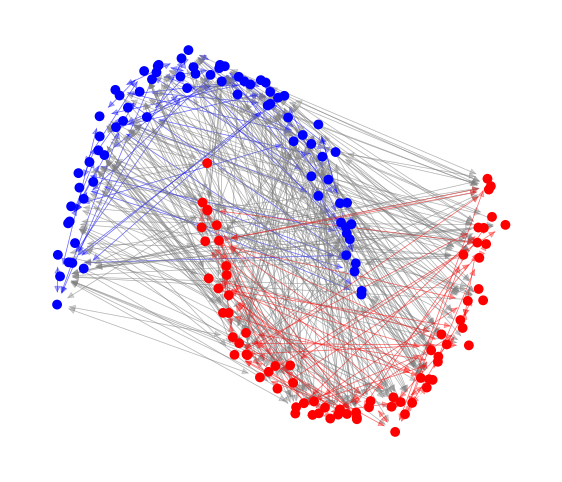

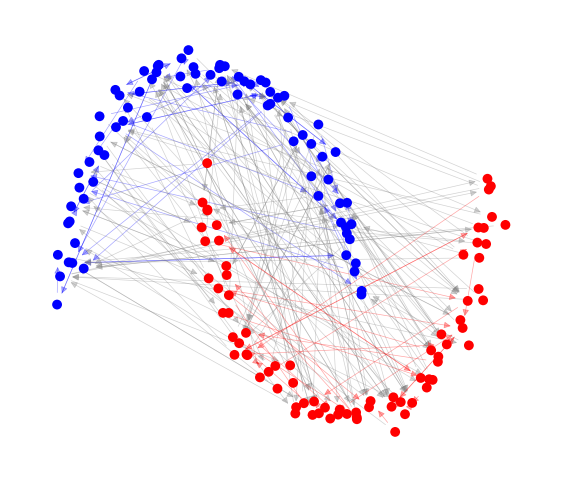

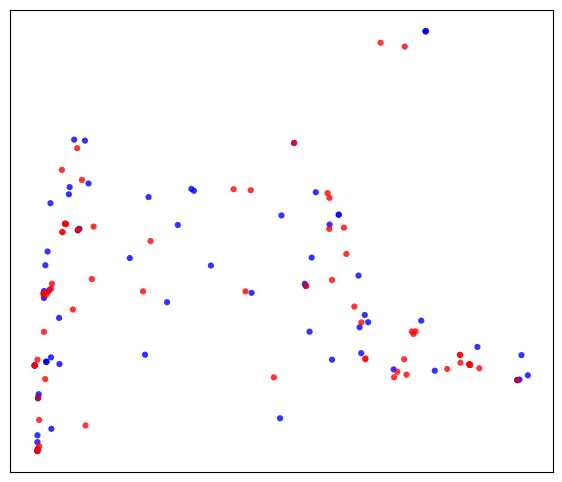

In [17]:
# SparseGAT visualization helpers

def get_sparsegat_edge_weights(model):
    model.eval()
    with torch.no_grad():
        _ = model(features)
    g_local = model.gat_layers[0].g
    att = g_local.edata['a']
    weights = att.view(-1).detach().cpu()
    src, dst = g_local.edges()
    edge_index = torch.stack([src, dst], dim=0).cpu()
    return edge_index, weights


def get_sparsegat_embeddings(model):
    model.eval()
    with torch.no_grad():
        h = features
        edges = "__ALL__"
        h, edges = model.gat_layers[0](h, edges)
        h = model.activation(h.flatten(1))
        for l in range(1, model.num_layers):
            h, _ = model.gat_layers[l](h, edges, skip=1)
            h = model.activation(h.flatten(1))
    return h.detach().cpu()

# Paper-ready figures (SparseGAT)
fig_dir = ensure_dir('KDDFigures')
class_pair = select_two_classes(data.y, None)

edge_index_all, edge_weights = get_sparsegat_edge_weights(model)
# num_edges = edge_weights.numel()
# top_k = max(1, int(0.2 * num_edges))
# top_idx = torch.topk(edge_weights, top_k).indices
# sampled_edge_index = edge_index_all[:, top_idx]

sampled_edge_index = topk_per_neighbor(
    edge_index_all,
    edge_weights,
    frac=0.2,      # top 20% per node
    num_nodes=data.num_nodes,  # recommended if you have it
    min_k=1
)

pos = compute_graph_layout(data, dataset_name=DATASET_NAME, seed=42)

fig_full, ax_full = plt.subplots(figsize=FIGSIZE)
plot_graph_two_class(
    data,
    ax=ax_full,
    pos=pos,
    class_pair=class_pair,
    dataset_name=DATASET_NAME,
#     title='Original dense graph (SparseGAT)',
    node_size=50,
    highlight_colors=('blue', 'red'),
)
save_figure(fig_full, fig_dir / 'SparseGATOriginalGraph.pdf', dpi=300)

fig_sparse, ax_sparse = plt.subplots(figsize=FIGSIZE)
plot_graph_two_class(
    data,
    edge_index=sampled_edge_index,
    ax=ax_sparse,
    pos=pos,
    class_pair=class_pair,
    dataset_name=DATASET_NAME,
#     title='SparseGAT subgraph (top 20%)',
    node_size=50,
    highlight_colors=('blue', 'red'),
)
save_figure(fig_sparse, fig_dir / 'SparseGATSparseGraph.pdf', dpi=300)

embeddings = get_sparsegat_embeddings(model)
emb_2d = reduce_embeddings_2d(embeddings, method='pca', random_state=42)
fig_emb, ax_emb = plt.subplots(figsize=FIGSIZE)
plot_embeddings_2d(
    emb_2d,
    data.y,
    class_pair=class_pair,
    ax=ax_emb,
#     title='SparseGAT embeddings (PCA)',
    highlight_colors=('blue', 'red'),
)
save_figure(fig_emb, fig_dir / 'SparseGATEmbedding.pdf', dpi=300)

plt.show()


In [18]:
result  = count_edges_with_different_labels(data, sampled_edge_index)
print(f"Original graph: {result['original_graph']['different_label_edges']} edges with different labels "
              f"out of {result['original_graph']['total_edges']} total edges "
              f"(Edge homophily: {100-result['original_graph']['percentage']:.2f}%).")

print(f"Sampled graph: {result['sampled_graph']['different_label_edges']} edges with different labels "
      f"out of {result['sampled_graph']['total_edges']} total edges "
      f"(Edge homophily: {100-result['sampled_graph']['percentage']:.2f}%).")

Original graph: 570 edges with different labels out of 846 total edges (Edge homophily: 32.62%).
Sampled graph: 146 edges with different labels out of 226 total edges (Edge homophily: 35.40%).
